In [1]:
# Energy prediction 3 (ASHRAE)
from sklearn.model_selection import StratifiedKFold
from scipy.signal import savgol_filter as sg
import holidays
from pandas.api.types import is_categorical_dtype
from pandas.api.types import is_datetime64_any_dtype as is_datetime

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np  # linear algebra
from tqdm import tqdm_notebook as tqdm

from pathlib import Path

import os
import gc

import warnings
warnings.filterwarnings('ignore')

black_day = 10

debug = False
num_rounds = 200

folds = 3  # 3, 6, 12

ucf_year = [2017, 2018]  # ucf data year used in train

predmode = 'all'  

%matplotlib inline

import seaborn as sns

from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import mean_squared_error
from keras import backend as k


import tensorflow as tf
from tensorflow import keras
import keras.layers as layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.optimizers import *

from pathlib import Path

import warnings
warnings.filterwarnings('ignore')


In [2]:
# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
# Modified to support timestamp type, categorical type
# Modified to add option to use float16 or not. feather format does not support float16.


def reduce_mem_usage(df, use_float16=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            # skip datetime type or categorical type
            continue
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(
        100 * (start_mem - end_mem) / start_mem))

    return df

In [3]:
zone_dict = {0: 4, 1: 0, 2: 7, 3: 4, 4: 7, 5: 0, 6: 4, 7: 4,
             8: 4, 9: 5, 10: 7, 11: 4, 12: 0, 13: 5, 14: 4, 15: 4}


def set_local(df):
    for sid, zone in zone_dict.items():
        sids = df.site_id == sid
        df.loc[sids, 'timestamp'] = df[sids].timestamp - pd.offsets.Hour(zone)

In [4]:
root = Path('/home/joydipb/Documents/CMT307-Coursework-2-Group-19') # Change the path to the source file path, use Memory_Management.py to generate files in feather format 
train_df = pd.read_feather(root/'train.feather')
weather_train_df = pd.read_feather(root/'weather_train.feather')
building_meta_df = pd.read_feather(root/'building_metadata.feather')

building_meta_df = building_meta_df.merge(
    train_df[['building_id', 'meter']].drop_duplicates(), on='building_id')

# Set group  (site-meter) for training models

building_meta_df['groupNum_train'] = building_meta_df['site_id'].astype(
    'int')*10 + building_meta_df['meter'].astype('int')

building_meta_df


,site_id,building_id,primary_use,square_feet,year_built,floor_count,meter,groupNum_train
0,0,0,Education,7432,2008.0,NaN,0,0
1,0,1,Education,2720,2004.0,NaN,0,0
2,0,2,Education,5376,1991.0,NaN,0,0
3,0,3,Education,23685,2002.0,NaN,0,0
4,0,4,Education,116607,1975.0,NaN,0,0
...,...,...,...,...,...,...,...,...
2375,15,1444,Entertainment/public assembly,19619,1914.0,NaN,0,150
2376,15,1445,Education,4298,NaN,NaN,0,150
2377,15,1446,Entertainment/public assembly,11265,1997.0,NaN,0,150
2378,15,1447,Lodging/residential,29775,2001.0,NaN,0,150


In [5]:
building_meta_df['floor_area'] = building_meta_df.square_feet / \
    building_meta_df.floor_count

In [6]:
# Site Specific Holiday


en_holidays = holidays.England()
ir_holidays = holidays.Ireland()
ca_holidays = holidays.Canada()
us_holidays = holidays.UnitedStates()


def add_holiyday(df_weather):
    en_idx = df_weather.query('site_id == 1 or site_id == 5').index
    ir_idx = df_weather.query('site_id == 12').index
    ca_idx = df_weather.query('site_id == 7 or site_id == 11').index
    us_idx = df_weather.query(
        'site_id == 0 or site_id == 2 or site_id == 3 or site_id == 4 or site_id == 6 or site_id == 8 or site_id == 9 or site_id == 10 or site_id == 13 or site_id == 14 or site_id == 15').index

    df_weather['IsHoliday'] = 0
    df_weather.loc[en_idx, 'IsHoliday'] = df_weather.loc[en_idx,
                                                         'timestamp'].apply(lambda x: en_holidays.get(x, default=0))
    df_weather.loc[ir_idx, 'IsHoliday'] = df_weather.loc[ir_idx,
                                                         'timestamp'].apply(lambda x: ir_holidays.get(x, default=0))
    df_weather.loc[ca_idx, 'IsHoliday'] = df_weather.loc[ca_idx,
                                                         'timestamp'].apply(lambda x: ca_holidays.get(x, default=0))
    df_weather.loc[us_idx, 'IsHoliday'] = df_weather.loc[us_idx,
                                                         'timestamp'].apply(lambda x: us_holidays.get(x, default=0))

    holiday_idx = df_weather['IsHoliday'] != 0
    df_weather.loc[holiday_idx, 'IsHoliday'] = 1
    df_weather['IsHoliday'] = df_weather['IsHoliday'].astype(np.uint8)

In [7]:
set_local(weather_train_df)
add_holiyday(weather_train_df)

In [8]:
train_df = train_df.query('not (building_id == 954 & meter_reading == 0)')
train_df = train_df.query('not (building_id == 1221 & meter_reading == 0)')

In [9]:
# Removing buildings with meter == 0 before first initial reading.
train_df = train_df.query(
    'not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20 18")')
train_df = train_df.query(
    'not (building_id == 681 & meter == 0 & timestamp <= "2016-04-27")')
train_df = train_df.query(
    'not (building_id == 761 & meter == 0 & timestamp <= "2016-09-02")')
train_df = train_df.query(
    'not (building_id == 799 & meter == 0 & timestamp <= "2016-09-02")')
train_df = train_df.query(
    'not (building_id == 802 & meter == 0 & timestamp <= "2016-08-24")')
train_df = train_df.query(
    'not (building_id == 1073 & meter == 0 & timestamp <= "2016-10-26")')
train_df = train_df.query(
    'not (building_id == 1094 & meter == 0 & timestamp <= "2016-09-08")')
train_df = train_df.query(
    'not (building_id == 29 & meter == 0 & timestamp <= "2016-08-10")')
train_df = train_df.query(
    'not (building_id == 40 & meter == 0 & timestamp <= "2016-06-04")')
train_df = train_df.query(
    'not (building_id == 45 & meter == 0 & timestamp <= "2016-07")')
train_df = train_df.query(
    'not (building_id == 106 & meter == 0 & timestamp <= "2016-11")')
train_df = train_df.query(
    'not (building_id == 107 & meter == 0 & timestamp >= "2016-11-10")')
train_df = train_df.query(
    'not (building_id == 112 & meter == 0 & timestamp < "2016-10-31 15")')
train_df = train_df.query(
    'not (building_id == 144 & meter == 0 & timestamp > "2016-05-14" & timestamp < "2016-10-31")')
train_df = train_df.query(
    'not (building_id == 147 & meter == 0 & timestamp > "2016-06-05 19" & timestamp < "2016-07-18 15")')
train_df = train_df.query(
    'not (building_id == 171 & meter == 0 & timestamp <= "2016-07-05")')
train_df = train_df.query(
    'not (building_id == 177 & meter == 0 & timestamp > "2016-06-04" & timestamp < "2016-06-25")')
train_df = train_df.query(
    'not (building_id == 258 & meter == 0 & timestamp > "2016-09-26" & timestamp < "2016-12-12")')
train_df = train_df.query(
    'not (building_id == 258 & meter == 0 & timestamp > "2016-08-30" & timestamp < "2016-09-08")')
train_df = train_df.query(
    'not (building_id == 258 & meter == 0 & timestamp > "2016-09-18" & timestamp < "2016-09-25")')
train_df = train_df.query(
    'not (building_id == 260 & meter == 0 & timestamp <= "2016-05-11")')
train_df = train_df.query(
    'not (building_id == 269 & meter == 0 & timestamp > "2016-06-04" & timestamp < "2016-06-25")')
train_df = train_df.query(
    'not (building_id == 304 & meter == 0 & timestamp >= "2016-11-20")')
train_df = train_df.query(
    'not (building_id == 545 & meter == 0 & timestamp > "2016-01-17" & timestamp < "2016-02-10")')
train_df = train_df.query(
    'not (building_id == 604 & meter == 0 & timestamp < "2016-11-21")')
train_df = train_df.query(
    'not (building_id == 693 & meter == 0 & timestamp > "2016-09-07" & timestamp < "2016-11-23")')
train_df = train_df.query(
    'not (building_id == 693 & meter == 0 & timestamp > "2016-07-12" & timestamp < "2016-05-29")')
train_df = train_df.query(
    'not (building_id == 723 & meter == 0 & timestamp > "2016-10-06" & timestamp < "2016-11-22")')
train_df = train_df.query(
    'not (building_id == 733 & meter == 0 & timestamp > "2016-05-29" & timestamp < "2016-06-22")')
train_df = train_df.query(
    'not (building_id == 733 & meter == 0 & timestamp > "2016-05-19" & timestamp < "2016-05-20")')
train_df = train_df.query(
    'not (building_id == 803 & meter == 0 & timestamp > "2016-9-25")')
train_df = train_df.query(
    'not (building_id == 815 & meter == 0 & timestamp > "2016-05-17" & timestamp < "2016-11-17")')
train_df = train_df.query(
    'not (building_id == 848 & meter == 0 & timestamp > "2016-01-15" & timestamp < "2016-03-20")')
train_df = train_df.query(
    'not (building_id == 857 & meter == 0 & timestamp > "2016-04-13")')
train_df = train_df.query(
    'not (building_id == 909 & meter == 0 & timestamp < "2016-02-02")')
train_df = train_df.query(
    'not (building_id == 909 & meter == 0 & timestamp < "2016-06-23")')
train_df = train_df.query(
    'not (building_id == 1008 & meter == 0 & timestamp > "2016-10-30" & timestamp < "2016-11-21")')
train_df = train_df.query(
    'not (building_id == 1113 & meter == 0 & timestamp < "2016-07-27")')
train_df = train_df.query(
    'not (building_id == 1153 & meter == 0 & timestamp < "2016-01-20")')
train_df = train_df.query(
    'not (building_id == 1169 & meter == 0 & timestamp < "2016-08-03")')
train_df = train_df.query(
    'not (building_id == 1170 & meter == 0 & timestamp > "2016-06-30" & timestamp < "2016-07-05")')
train_df = train_df.query(
    'not (building_id == 1221 & meter == 0 & timestamp < "2016-11-04")')
train_df = train_df.query(
    'not (building_id == 1225 & meter == 0 & timestamp > "2016-09-28 07" & timestamp < "2016-10-20 13")')
train_df = train_df.query(
    'not (building_id == 1234 & meter == 0 & timestamp > "2016-09-28 07" & timestamp < "2016-10-20 13")')
train_df = train_df.query(
    'not (building_id >= 1233 & building_id <= 1234 & meter == 0 & timestamp > "2016-01-13 22" & timestamp < "2016-03-08 12")')
train_df = train_df.query(
    'not (building_id == 1241 & meter == 0 & timestamp > "2016-07-14" & timestamp < "2016-11-19")')
train_df = train_df.query(
    'not (building_id == 1250 & meter == 0 & timestamp > "2016-09-28 07" & timestamp < "2016-10-20 13")')
train_df = train_df.query(
    'not (building_id == 1255 & meter == 0 & timestamp > "2016-09-28 07" & timestamp < "2016-10-20 13")')
train_df = train_df.query(
    'not (building_id == 1264 & meter == 0 & timestamp > "2016-08-23")')
train_df = train_df.query(
    'not (building_id == 1265 & meter == 0 & timestamp > "2016-05-06" & timestamp < "2016-05-26")')
train_df = train_df.query(
    'not (building_id == 1272 & meter == 0 & timestamp > "2016-09-28 07" & timestamp < "2016-10-20 13")')
train_df = train_df.query(
    'not (building_id >= 1275 & building_id <= 1280 & meter == 0 & timestamp > "2016-09-28 07" & timestamp < "2016-10-20 13")')
train_df = train_df.query(
    'not (building_id == 1283 & meter == 0 & timestamp > "2016-07-08" & timestamp < "2016-08-03")')
train_df = train_df.query(
    'not (building_id >= 1291 & building_id <= 1302 & meter == 0 & timestamp > "2016-09-28 07" & timestamp < "2016-10-20 13")')
train_df = train_df.query(
    'not (building_id == 1303 & meter == 0 & timestamp > "2016-07-25 22" & timestamp < "2016-07-27 16")')
train_df = train_df.query(
    'not (building_id == 1303 & meter == 0 & timestamp > "2016-01-26" & timestamp < "2016-06-02 12")')
train_df = train_df.query(
    'not (building_id == 1319 & meter == 0 & timestamp > "2016-05-17 16" & timestamp < "2016-06-07 12")')
train_df = train_df.query(
    'not (building_id == 1319 & meter == 0 & timestamp > "2016-08-18 14" & timestamp < "2016-09-02 14")')
train_df = train_df.query(
    'not (building_id == 1322 & meter == 0 & timestamp > "2016-09-28 07" & timestamp < "2016-10-20 13")')

# 2nd cleaning
train_df = train_df.query(
    'not (building_id >= 874 & building_id <= 997 & meter == 0 & timestamp > "2016-10-14 22" & timestamp < "2016-10-17 08")')
train_df = train_df.query(
    'not (building_id >= 874 & building_id <= 997 & meter == 0 & timestamp > "2016-07-01 14" & timestamp < "2016-07-05 06")')
train_df = train_df.query(
    'not (building_id >= 874 & building_id <= 997 & meter == 1 & timestamp > "2016-10-14 22" & timestamp < "2016-10-17 08")')
train_df = train_df.query(
    'not (building_id >= 874 & building_id <= 997 & meter == 1 & timestamp > "2016-07-01 14" & timestamp < "2016-07-05 06")')
train_df = train_df.query(
    'not (building_id >= 874 & building_id <= 997 & meter == 2 & timestamp > "2016-10-14 22" & timestamp < "2016-10-17 08")')
train_df = train_df.query(
    'not (building_id >= 874 & building_id <= 997 & meter == 2 & timestamp > "2016-07-01 14" & timestamp < "2016-07-05 06")')
train_df = train_df.query(
    'not (building_id == 1272 & meter == 1 & timestamp > "2016-09-28 07" & timestamp < "2016-10-20 13")')
train_df = train_df.query(
    'not (building_id >= 1291 & building_id <= 1297 & meter == 1 & timestamp > "2016-09-28 07" & timestamp < "2016-10-20 13")')
train_df = train_df.query(
    'not (building_id == 1300 & meter == 1 & timestamp > "2016-09-28 07" & timestamp < "2016-10-20 13")')
train_df = train_df.query(
    'not (building_id == 1302 & meter == 1 & timestamp > "2016-09-28 07" & timestamp < "2016-10-20 13")')
train_df = train_df.query(
    'not (building_id >= 1291 & building_id <= 1299 & meter == 2 & timestamp > "2016-09-28 07" & timestamp < "2016-10-20 13")')
train_df = train_df.query(
    'not (building_id == 1221 & meter == 0 & timestamp > "2016-09-28 07" & timestamp < "2016-10-20 13")')
train_df = train_df.query(
    'not (building_id >= 1225 & building_id <= 1226 & meter == 0 & timestamp > "2016-09-28 07" & timestamp < "2016-10-20 13")')
train_df = train_df.query(
    'not (building_id >= 1233 & building_id <= 1234 & meter == 0 & timestamp > "2016-09-28 07" & timestamp < "2016-10-20 13")')
train_df = train_df.query(
    'not (building_id == 1241 & meter == 0 & timestamp > "2016-09-28 07" & timestamp < "2016-10-20 13")')
train_df = train_df.query(
    'not (building_id == 1223 & meter == 1 & timestamp > "2016-09-28 07" & timestamp < "2016-10-20 13")')
train_df = train_df.query(
    'not (building_id == 1226 & meter == 1 & timestamp > "2016-09-28 07" & timestamp < "2016-10-20 13")')
train_df = train_df.query(
    'not (building_id >= 1233 & building_id <= 1234 & meter == 1 & timestamp > "2016-09-28 07" & timestamp < "2016-10-20 13")')
train_df = train_df.query(
    'not (building_id >= 1225 & building_id <= 1226 & meter == 2 & timestamp > "2016-09-28 07" & timestamp < "2016-10-20 13")')
train_df = train_df.query(
    'not (building_id == 1305 & meter == 2 & timestamp > "2016-09-28 07" & timestamp < "2016-10-20 13")')
train_df = train_df.query(
    'not (building_id == 1307 & meter == 2 & timestamp > "2016-09-28 07" & timestamp < "2016-10-20 13")')
train_df = train_df.query(
    'not (building_id == 1223 & meter == 3 & timestamp > "2016-09-28 07" & timestamp < "2016-10-20 13")')
train_df = train_df.query(
    'not (building_id == 1231 & meter == 3 & timestamp > "2016-09-28 07" & timestamp < "2016-10-20 13")')
train_df = train_df.query(
    'not (building_id >= 1233 & building_id <= 1234 & meter == 3 & timestamp > "2016-09-28 07" & timestamp < "2016-10-20 13")')
train_df = train_df.query(
    'not (building_id == 1272 & meter == 3 & timestamp > "2016-09-28 07" & timestamp < "2016-10-20 13")')
train_df = train_df.query(
    'not (building_id >= 1275 & building_id <= 1297 & meter == 3 & timestamp > "2016-09-28 07" & timestamp < "2016-10-20 13")')
train_df = train_df.query(
    'not (building_id == 1300 & meter == 3 & timestamp > "2016-09-28 07" & timestamp < "2016-10-20 13")')
train_df = train_df.query(
    'not (building_id == 1302 & meter == 3 & timestamp > "2016-09-28 07" & timestamp < "2016-10-20 13")')
train_df = train_df.query(
    'not (building_id == 1293 & meter == 3 & timestamp > "2016-09-28 07" & timestamp < "2016-10-25 12")')
train_df = train_df.query(
    'not (building_id == 1302 & meter == 3 & timestamp > "2016-09-28 07" & timestamp < "2016-10-25 12")')
train_df = train_df.query(
    'not (building_id == 1223 & meter == 0 & timestamp > "2016-9-28 07" & timestamp < "2016-10-11 18")')
train_df = train_df.query(
    'not (building_id == 1225 & meter == 1 & timestamp > "2016-8-22 23" & timestamp < "2016-10-11 14")')
train_df = train_df.query(
    'not (building_id == 1230 & meter == 1 & timestamp > "2016-8-22 08" & timestamp < "2016-10-05 18")')
train_df = train_df.query(
    'not (building_id == 904 & meter == 0 & timestamp < "2016-02-17 08")')
train_df = train_df.query(
    'not (building_id == 986 & meter == 0 & timestamp < "2016-02-17 08")')
train_df = train_df.query(
    'not (building_id == 954 & meter == 0 & timestamp < "2016-08-08 11")')
train_df = train_df.query(
    'not (building_id == 954 & meter == 0 & timestamp < "2016-06-23 08")')
train_df = train_df.query(
    'not (building_id >= 745 & building_id <= 770 & meter == 1 & timestamp > "2016-10-05 01" & timestamp < "2016-10-10 09")')
train_df = train_df.query(
    'not (building_id >= 774 & building_id <= 787 & meter == 1 & timestamp > "2016-10-05 01" & timestamp < "2016-10-10 09")')

# 3rd cleaning hourly spikes
train_df = train_df.query(
    'not (building_id >= 874 & building_id <= 997 & meter == 0 & timestamp > "2016-05-11 09" & timestamp < "2016-05-12 01")')
train_df = train_df.query(
    'not (building_id >= 874 & building_id <= 997 & meter == 1 & timestamp > "2016-05-11 09" & timestamp < "2016-05-12 01")')
train_df = train_df.query(
    'not (building_id >= 874 & building_id <= 997 & meter == 2 & timestamp > "2016-05-11 09" & timestamp < "2016-05-12 01")')

train_df = train_df.query(
    'not (building_id >= 874 & building_id <= 997 & meter == 0 & timestamp == "2016-02-26 01")')
train_df = train_df.query(
    'not (building_id >= 874 & building_id <= 997 & meter == 1 & timestamp == "2016-02-26 01")')
train_df = train_df.query(
    'not (building_id >= 874 & building_id <= 997 & meter == 2 & timestamp == "2016-02-26 01")')

train_df = train_df.query(
    'not (building_id >= 874 & building_id <= 997 & meter == 0 & timestamp > "2016-03-29 10" & timestamp < "2016-03-30 12")')
train_df = train_df.query(
    'not (building_id >= 874 & building_id <= 997 & meter == 1 & timestamp > "2016-03-29 10" & timestamp < "2016-03-30 12")')
train_df = train_df.query(
    'not (building_id >= 874 & building_id <= 997 & meter == 2 & timestamp > "2016-03-29 10" & timestamp < "2016-03-30 12")')

train_df = train_df.query(
    'not (building_id >= 874 & building_id <= 997 & meter == 0 & timestamp > "2016-01-19 23" & timestamp < "2016-01-28 15")')
train_df = train_df.query(
    'not (building_id >= 874 & building_id <= 997 & meter == 1 & timestamp > "2016-01-19 23" & timestamp < "2016-01-28 15")')
train_df = train_df.query(
    'not (building_id >= 874 & building_id <= 997 & meter == 2 & timestamp > "2016-01-19 23" & timestamp < "2016-01-28 15")')

train_df = train_df.query(
    'not (building_id != 1227 & building_id != 1281 & building_id != 1314 & building_id >=1223 & building_id < 1335 & meter==0 & meter_reading==0)')

# 4th cleaning
train_df = train_df.query(
    'not (building_id >= 1223 & building_id <= 1324 & meter==1 & timestamp > "2016-07-16 04" & timestamp < "2016-07-19 11")')
train_df = train_df.query(
    'not (building_id == 107 & meter == 0 & timestamp <= "2016-07-06")')
train_df = train_df.query(
    'not (building_id == 180 & timestamp >= "2016-02-17 12")')
train_df = train_df.query('not (building_id == 182 & meter == 0)')
train_df = train_df.query(
    'not (building_id == 191 & meter == 0 & timestamp >= "2016-12-22 09")')
train_df = train_df.query(
    'not (building_id == 192 & meter == 1 & timestamp >= "2016-05-09 18")')
train_df = train_df.query(
    'not (building_id == 192 & meter == 3 & timestamp >= "2016-03-29 05" & timestamp <= "2016-04-04 08")')
train_df = train_df.query(
    'not (building_id == 207 & meter == 1 & timestamp > "2016-07-02 20" & timestamp < "2016-08-25 12")')
train_df = train_df.query(
    'not (building_id == 258 & timestamp > "2016-09-18" & timestamp < "2016-12-12 13")')
train_df = train_df.query(
    'not (building_id == 258 & timestamp > "2016-08-29 08" & timestamp < "2016-09-08 14")')
train_df = train_df.query(
    'not (building_id == 257 & meter == 1 & timestamp < "2016-03-25 16")')
train_df = train_df.query(
    'not (building_id == 260 & meter == 1 & timestamp > "2016-05-10 17" & timestamp < "2016-08-17 11")')
train_df = train_df.query(
    'not (building_id == 260 & meter == 1 & timestamp > "2016-08-28 01" & timestamp < "2016-10-31 13")')
train_df = train_df.query(
    'not (building_id == 220 & meter == 1 & timestamp > "2016-09-23 01" & timestamp < "2016-09-23 12")')
train_df = train_df.query(
    'not (building_id == 281 & meter == 1 & timestamp > "2016-10-25 08" & timestamp < "2016-11-04 15")')
train_df = train_df.query(
    'not (building_id == 273 & meter == 1 & timestamp > "2016-04-03 04" & timestamp < "2016-04-29 15")')
train_df = train_df.query(
    'not (building_id == 28 & meter == 0 & timestamp < "2016-10-14 20")')
train_df = train_df.query(
    'not (building_id == 71 & meter == 0 & timestamp < "2016-08-18 20")')
train_df = train_df.query(
    'not (building_id == 76 & meter == 0 & timestamp > "2016-06-04 09" & timestamp < "2016-06-04 14")')
train_df = train_df.query(
    'not (building_id == 101 & meter == 0 & timestamp > "2016-10-12 13" & timestamp < "2016-10-12 18")')
train_df = train_df.query(
    'not (building_id == 7 & meter == 1 & timestamp > "2016-11-03 09" & timestamp < "2016-11-28 14")')
train_df = train_df.query(
    'not (building_id == 9 & meter == 1 & timestamp > "2016-12-06 08")')
train_df = train_df.query(
    'not (building_id == 43 & meter == 1 & timestamp > "2016-04-03 08" & timestamp < "2016-06-06 13")')
train_df = train_df.query(
    'not (building_id == 60 & meter == 1 & timestamp > "2016-05-01 17" & timestamp < "2016-05-01 21")')
train_df = train_df.query(
    'not (building_id == 75 & meter == 1 & timestamp > "2016-08-05 13" & timestamp < "2016-08-26 12")')
train_df = train_df.query(
    'not (building_id == 95 & meter == 1 & timestamp > "2016-08-08 10" & timestamp < "2016-08-26 13")')
train_df = train_df.query(
    'not (building_id == 97 & meter == 1 & timestamp > "2016-08-08 14" & timestamp < "2016-08-25 14")')
train_df = train_df.query(
    'not (building_id == 1232 & meter == 1 & timestamp > "2016-06-23 16" & timestamp < "2016-08-31 20")')
train_df = train_df.query(
    'not (building_id == 1236 & meter == 1 & meter_reading >= 3000)')
train_df = train_df.query(
    'not (building_id == 1239 & meter == 1 & timestamp > "2016-03-11 16" & timestamp < "2016-03-27 17")')
train_df = train_df.query(
    'not (building_id == 1264 & meter == 1 & timestamp > "2016-08-22 17" & timestamp < "2016-09-22 20")')
train_df = train_df.query(
    'not (building_id == 1264 & meter == 1 & timestamp > "2016-09-28 07" & timestamp < "2016-10-20 13")')
train_df = train_df.query(
    'not (building_id == 1269 & meter == 1 & meter_reading >= 2000)')
train_df = train_df.query(
    'not (building_id == 1272 & meter == 1 & timestamp > "2016-08-11 12" & timestamp < "2016-08-30 19")')
train_df = train_df.query(
    'not (building_id == 1273 & meter == 1 & timestamp > "2016-05-31 14" & timestamp < "2016-06-17")')
train_df = train_df.query(
    'not (building_id == 1276 & meter == 1 & timestamp < "2016-02-03 23")')
train_df = train_df.query(
    'not (building_id == 1280 & meter == 1 & timestamp > "2016-05-18" & timestamp < "2016-05-26 09")')
train_df = train_df.query(
    'not (building_id == 1280 & meter == 1 & timestamp > "2016-02-28 23" & timestamp < "2016-05-02 05")')
train_df = train_df.query(
    'not (building_id == 1280 & meter == 1 & timestamp > "2016-06-12 01" & timestamp < "2016-7-07 06")')
train_df = train_df.query(
    'not (building_id == 1288 & meter == 1 & timestamp > "2016-07-07 15" & timestamp < "2016-08-12 17")')
train_df = train_df.query(
    'not (building_id == 1311 & meter == 1 & timestamp > "2016-04-25 18" & timestamp < "2016-05-13 14")')
train_df = train_df.query('not (building_id == 1099 & meter == 2)')

train_df = train_df.query(
    'not (building_id == 1329 & meter == 0 & timestamp > "2016-04-28 00" & timestamp < "2016-04-28 07")')
train_df = train_df.query(
    'not (building_id == 1331 & meter == 0 & timestamp > "2016-04-28 00" & timestamp < "2016-04-28 07")')
train_df = train_df.query(
    'not (building_id == 1427 & meter == 0 & timestamp > "2016-04-11 10" & timestamp < "2016-04-11 14")')
train_df = train_df.query(
    'not (building_id == 1426 & meter == 2 & timestamp > "2016-05-03 09" & timestamp < "2016-05-03 14")')
train_df = train_df.query(
    'not (building_id == 1345 & meter == 0 & timestamp < "2016-03-01")')
train_df = train_df.query(
    'not (building_id == 1346 & timestamp < "2016-03-01")')
train_df = train_df.query(
    'not (building_id == 1359 & meter == 0 & timestamp > "2016-04-25 17" & timestamp < "2016-07-22 14")')
train_df = train_df.query(
    'not (building_id == 1365 & meter == 0 & timestamp > "2016-08-19 00" & timestamp < "2016-08-19 07")')
train_df = train_df.query(
    'not (building_id == 1365 & meter == 0 & timestamp > "2016-06-18 22" & timestamp < "2016-06-19 06")')

train_df = train_df.query(
    'not (building_id == 18 & meter == 0 & timestamp > "2016-06-04 09" & timestamp < "2016-06-04 16")')
train_df = train_df.query(
    'not (building_id == 18 & meter == 0 & timestamp > "2016-11-05 05" & timestamp < "2016-11-05 15")')
train_df = train_df.query(
    'not (building_id == 101 & meter == 0 & meter_reading > 800)')

train_df = train_df.query(
    'not (building_id == 1384 & meter == 0 & meter_reading == 0 )')
train_df = train_df.query(
    'not (building_id >= 1289 & building_id <= 1301 & meter == 2 & meter_reading == 0)')
train_df = train_df.query(
    'not (building_id == 1243 & meter == 2 & meter_reading == 0)')
train_df = train_df.query(
    'not (building_id == 1263 & meter == 2 & meter_reading == 0)')
train_df = train_df.query(
    'not (building_id == 1284 & meter == 2 & meter_reading == 0)')
train_df = train_df.query(
    'not (building_id == 1286 & meter == 2 & meter_reading == 0)')
train_df = train_df.query(
    'not (building_id == 1263 & meter == 0 & timestamp > "2016-11-10 11" & timestamp < "2016-11-10 15")')

train_df = train_df.query(
    'not (building_id == 1238 & meter == 2 & meter_reading == 0)')
train_df = train_df.query(
    'not (building_id == 1329 & meter == 2 & timestamp > "2016-11-21 12" & timestamp < "2016-11-29 12")')
train_df = train_df.query(
    'not (building_id == 1249 & meter == 2 & meter_reading == 0)')

train_df = train_df.query(
    'not (building_id == 1250 & meter == 2 & meter_reading == 0)')
train_df = train_df.query(
    'not (building_id == 1256 & meter == 2 & timestamp > "2016-03-05 18" & timestamp < "2016-03-05 22")')
train_df = train_df.query(
    'not (building_id == 1256 & meter == 2 & timestamp > "2016-03-27 00" & timestamp < "2016-03-27 23")')
train_df = train_df.query(
    'not (building_id == 1256 & meter == 2 & timestamp > "2016-04-11 09" & timestamp < "2016-04-13 03")')
train_df = train_df.query(
    'not (building_id == 1256 & meter == 2 & timestamp > "2016-04-29 00" & timestamp < "2016-04-30 15")')
train_df = train_df.query(
    'not (building_id == 1303 & meter == 2 & timestamp < "2016-06-06 19")')
train_df = train_df.query(
    'not (building_id >= 1223 & building_id <= 1324 & meter == 1 & timestamp > "2016-08-11 17" & timestamp < "2016-08-12 17")')
train_df = train_df.query(
    'not (building_id >= 1223 & building_id <= 1324 & building_id != 1296 & building_id != 129 & building_id != 1298 & building_id != 1299 & meter == 2 & timestamp > "2016-08-11 17" & timestamp < "2016-08-12 17")')
train_df = train_df.query(
    'not (building_id >= 1223 & building_id <= 1324 & meter == 3 & timestamp > "2016-08-11 17" & timestamp < "2016-08-12 17")')

train_df = train_df.reset_index()

print('after', len(train_df))
gc.collect()

after 19456584


261

In [10]:
# Site-0 Correction¶
# https://www.kaggle.com/c/ashrae-energy-prediction/discussion/119261#latest-684102
site_0_bids = building_meta_df[building_meta_df.site_id ==
                               0].building_id.unique()
print(len(site_0_bids), len(
    train_df[train_df.building_id.isin(site_0_bids)].building_id.unique()))
train_df[train_df.building_id.isin(
    site_0_bids) & (train_df.meter == 0)].head(10)

105 105


,index,building_id,meter,timestamp,meter_reading
7054137,7579069,0,0,2016-05-20 19:00:00,277.802002
7054138,7579070,1,0,2016-05-20 19:00:00,125.863998
7054139,7579071,2,0,2016-05-20 19:00:00,32.762901
7054140,7579072,3,0,2016-05-20 19:00:00,336.843994
7054141,7579073,4,0,2016-05-20 19:00:00,1625.859985
7054142,7579074,5,0,2016-05-20 19:00:00,45.390301
7054143,7579075,6,0,2016-05-20 19:00:00,83.545403
7054144,7579076,7,0,2016-05-20 19:00:00,511.920013
7054146,7579078,8,0,2016-05-20 19:00:00,348.787994
7054147,7579079,9,0,2016-05-20 19:00:00,120.813004


In [11]:
train_df.loc[(train_df.building_id.isin(site_0_bids)) & (train_df.meter == 0), 'meter_reading'] = train_df[(
    train_df.building_id.isin(site_0_bids)) & (train_df.meter == 0)]['meter_reading'] * 0.2931

In [12]:
train_df[(train_df.building_id.isin(site_0_bids))
         & (train_df.meter == 0)].head(10)

,index,building_id,meter,timestamp,meter_reading
7054137,7579069,0,0,2016-05-20 19:00:00,81.423767
7054138,7579070,1,0,2016-05-20 19:00:00,36.890739
7054139,7579071,2,0,2016-05-20 19:00:00,9.602806
7054140,7579072,3,0,2016-05-20 19:00:00,98.728973
7054141,7579073,4,0,2016-05-20 19:00:00,476.539551
7054142,7579074,5,0,2016-05-20 19:00:00,13.303897
7054143,7579075,6,0,2016-05-20 19:00:00,24.487158
7054144,7579076,7,0,2016-05-20 19:00:00,150.043762
7054146,7579078,8,0,2016-05-20 19:00:00,102.229759
7054147,7579079,9,0,2016-05-20 19:00:00,35.410290


In [13]:
train_df['date'] = train_df['timestamp'].dt.date
train_df['meter_reading_log1p'] = np.log1p(train_df['meter_reading'])

In [14]:
def preprocess(df):
    df["hour"] = df["timestamp"].dt.hour
    df["day"] = df["timestamp"].dt.day
    df["weekend"] = df["timestamp"].dt.weekday
    df["month"] = df["timestamp"].dt.month
    df["dayofweek"] = df["timestamp"].dt.dayofweek

In [15]:
preprocess(train_df)

In [16]:
weather_train_df = weather_train_df.groupby('site_id').apply(
    lambda group: group.interpolate(method='ffill', limit_direction='forward'))

In [17]:
# Adding some lag feature

def add_lag_feature(weather_df, window=3):
    group_df = weather_df.groupby('site_id')
    cols = ['air_temperature', 'cloud_coverage', 'dew_temperature',
            'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']
    rolled = group_df[cols].rolling(window=window, min_periods=0)
    lag_mean = rolled.mean().reset_index().astype(np.float16)
    lag_max = rolled.max().reset_index().astype(np.float16)
    lag_min = rolled.min().reset_index().astype(np.float16)
    lag_std = rolled.std().reset_index().astype(np.float16)
    for col in cols:
        weather_df[f'{col}_mean_lag{window}'] = lag_mean[col]
        weather_df[f'{col}_max_lag{window}'] = lag_max[col]
        weather_df[f'{col}_min_lag{window}'] = lag_min[col]
        weather_df[f'{col}_std_lag{window}'] = lag_std[col]

In [18]:
add_lag_feature(weather_train_df, window=3)
add_lag_feature(weather_train_df, window=72)

In [19]:
year_map = building_meta_df.year_built.value_counts()
building_meta_df['year_cnt'] = building_meta_df.year_built.map(year_map)

bid_map = train_df.building_id.value_counts()
train_df['bid_cnt'] = train_df.building_id.map(bid_map)

In [20]:
primary_use_list = building_meta_df['primary_use'].unique()
primary_use_dict = {key: value for value, key in enumerate(primary_use_list)}
print('primary_use_dict: ', primary_use_dict)
building_meta_df['primary_use'] = building_meta_df['primary_use'].map(
    primary_use_dict)

gc.collect()

primary_use_dict:  {'Education': 0, 'Lodging/residential': 1, 'Office': 2, 'Entertainment/public assembly': 3, 'Other': 4, 'Retail': 5, 'Parking': 6, 'Public services': 7, 'Warehouse/storage': 8, 'Food sales and service': 9, 'Religious worship': 10, 'Healthcare': 11, 'Utility': 12, 'Technology/science': 13, 'Manufacturing/industrial': 14, 'Services': 15}


0

In [21]:
train_df = reduce_mem_usage(train_df, use_float16=True)
building_meta_df = reduce_mem_usage(building_meta_df, use_float16=True)
weather_train_df = reduce_mem_usage(weather_train_df, use_float16=True)

Memory usage of dataframe is 1540.09 MB
Memory usage after optimization is: 593.78 MB
Decreased by 61.4%
Memory usage of dataframe is 0.11 MB
Memory usage after optimization is: 0.07 MB
Decreased by 40.6%
Memory usage of dataframe is 21.06 MB
Memory usage after optimization is: 19.33 MB
Decreased by 8.2%


In [22]:
# SG Filter for Weather

def add_sg(df):
    w = 11
    p = 2
    for si in df.site_id.unique():
        index = df.site_id == si
        df.loc[index, 'air_smooth'] = sg(df[index].air_temperature, w, p)
        df.loc[index, 'dew_smooth'] = sg(df[index].dew_temperature, w, p)

        df.loc[index, 'air_diff'] = sg(df[index].air_temperature, w, p, 1)
        df.loc[index, 'dew_diff'] = sg(df[index].dew_temperature, w, p, 1)

        df.loc[index, 'air_diff2'] = sg(df[index].air_temperature, w, p, 2)
        df.loc[index, 'dew_diff2'] = sg(df[index].dew_temperature, w, p, 2)

In [23]:
add_sg(weather_train_df)

In [24]:
# Feature Selection

category_cols = ['building_id', 'site_id', 'primary_use',
                 'IsHoliday', 'groupNum_train']  # , 'meter'
feature_cols = ['square_feet_np_log1p', 'year_built'] + [
    'hour', 'weekend',
    #    'day', # 'month' ,
    #    'dayofweek',
    #    'building_median'
    #    'square_feet'
] + [
    'air_temperature', 'cloud_coverage',
    'dew_temperature', 'precip_depth_1_hr',
    'sea_level_pressure',
    #'wind_direction', 'wind_speed',
    'air_temperature_mean_lag72',
    'air_temperature_max_lag72', 'air_temperature_min_lag72',
    'air_temperature_std_lag72', 'cloud_coverage_mean_lag72',
    'dew_temperature_mean_lag72', 'precip_depth_1_hr_mean_lag72',
    'sea_level_pressure_mean_lag72',
    # 'wind_direction_mean_lag72',
    'wind_speed_mean_lag72',
    'air_temperature_mean_lag3',
    'air_temperature_max_lag3',
    'air_temperature_min_lag3', 'cloud_coverage_mean_lag3',
    'dew_temperature_mean_lag3',
    'precip_depth_1_hr_mean_lag3',
    'sea_level_pressure_mean_lag3',
    #    'wind_direction_mean_lag3', 'wind_speed_mean_lag3',
    #    'floor_area',
    'year_cnt', 'bid_cnt',
    'dew_smooth', 'air_smooth',
    'dew_diff', 'air_diff',
    'dew_diff2', 'air_diff2'
 ]

In [25]:
train_df = train_df.merge(building_meta_df, on=[
                          'building_id', 'meter'], how='left')

In [26]:
train_df = reduce_mem_usage(train_df, use_float16=True)
weather_train_df = reduce_mem_usage(weather_train_df, use_float16=True)

Memory usage of dataframe is 1076.22 MB
Memory usage after optimization is: 1076.22 MB
Decreased by 0.0%
Memory usage of dataframe is 25.73 MB
Memory usage after optimization is: 20.93 MB
Decreased by 18.7%


In [27]:
train_df = train_df.merge(weather_train_df, on=[
                          'site_id', 'timestamp'], how='left')

In [28]:
train_df['square_feet_np_log1p'] = np.log1p(train_df['square_feet'])

In [29]:
train_df = reduce_mem_usage(train_df, use_float16=True)

Memory usage of dataframe is 3822.39 MB
Memory usage after optimization is: 3711.06 MB
Decreased by 2.9%


In [30]:
del weather_train_df
gc.collect() 

23

In [31]:
'''
--------------------------------------------------------------------------------
IMPLEMENTATION
'''

'\n--------------------------------------------------------------------------------\nIMPLEMENTATION\n'

In [32]:
# Get X_train and y_train
def create_X_y(train_df, groupNum_train):

    target_train_df = train_df[train_df['groupNum_train']
                               == groupNum_train].copy()
    
    X_train = target_train_df[feature_cols + category_cols]
    y_train = target_train_df['meter_reading_log1p'].values

    del target_train_df
    return X_train, y_train

In [33]:
# # Define RMSLE specifically for neural network
def NN_RMSLE(y_act, y_pred):
  return k.sqrt(k.mean(k.square(y_pred - y_act)))

In [34]:
# Split into train and validation sets
# train_xx, val_xx, train_yy, val_yy = train_test_split(train_x, train_y, test_size = 0.2, random_state = 42)

In [35]:
# Method to train LSTM model
def RNN_LSTM(train, val ):
       X_train, y_train = train
       X_valid, y_valid = val
       metric= 'val_loss'
       model = Sequential()
       early_stop = EarlyStopping(monitor = metric, mode = 'min', patience = 3)
       model_checkpoint = ModelCheckpoint("model_" + str(groupNum_train) + "[]",
                                          save_best_only=True, verbose=1, monitor=metric, mode='min')

       # Add LSTM Layers, etc
       # Add layers, etc
       model.add(Dense(units=64, activation='relu', input_dim=X_train.shape[1]))
       model.add(Dropout(0.2))
       model.add(Dense(units=32, activation='relu'))
       model.add(Dropout(0.2))
       model.add(Dense(units=16, activation='relu'))
       model.add(Dropout(0.2))
       model.add(Dense(units=1, activation='linear'))

       model.compile(loss='mse', optimizer='adam', metrics=[NN_RMSLE])
       model.summary()
       
       

       # Fit model
       model.fit(X_train, y_train, epochs=100, batch_size=64,
             validation_data=(X_valid, y_valid),
             callbacks=[early_stop, model_checkpoint], verbose=1)
       model.summary()

       y_pred_valid = model.predict(X_valid)

       print('---------- Evaluation on Training Data ----------')
       print("MSE: ", mean_squared_error(y_valid, y_pred_valid))
       print("")
       
       return model, y_pred_valid









In [36]:
from sklearn.model_selection import GroupKFold, StratifiedKFold
seed = 666
shuffle = False
kf = StratifiedKFold(n_splits=folds)

groupNum_train 0 (553329, 38)
cat_features [33, 34, 35, 36, 37]
[ 5  6  7  8  9 10 11]
train 368886 valid 184443
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                2496      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
         

2022-04-25 06:34:43.754202: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-25 06:34:43.755208: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


5753/5764 [============================>.] - ETA: 0s - loss: 706.1586 - NN_RMSLE: 3.9926
Epoch 1: val_loss improved from inf to 1.62218, saving model to model_0[]


2022-04-25 06:35:00.515077: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model_0[]/assets
5764/5764 [==============================] - 17s 3ms/step - loss: 704.8348 - NN_RMSLE: 3.9880 - val_loss: 1.6222 - val_NN_RMSLE: 1.2682
Epoch 2/100
5746/5764 [============================>.] - ETA: 0s - loss: 1.9746 - NN_RMSLE: 1.3976
Epoch 2: val_loss improved from 1.62218 to 1.52853, saving model to model_0[]
INFO:tensorflow:Assets written to: model_0[]/assets
5764/5764 [==============================] - 15s 3ms/step - loss: 1.9740 - NN_RMSLE: 1.3974 - val_loss: 1.5285 - val_NN_RMSLE: 1.2293
Epoch 3/100
5753/5764 [============================>.] - ETA: 0s - loss: 1.6061 - NN_RMSLE: 1.2617
Epoch 3: val_loss did not improve from 1.52853
5764/5764 [==============================] - 18s 3ms/step - loss: 1.6062 - NN_RMSLE: 1.2617 - val_loss: 1.5288 - val_NN_RMSLE: 1.2295
Epoch 4/100
5760/5764 [============================>.] - ETA: 0s - loss: 1.5565 - NN_RMSLE: 1.2421
Epoch 4: val_loss did not improve from 1.52853
5764/5764 [============

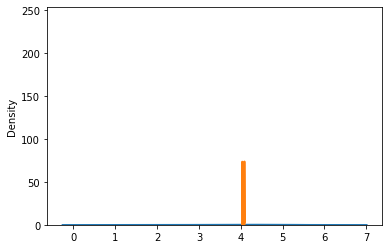

-------------------------------------------------------------
groupNum_train 1 (164229, 38)
cat_features [33, 34, 35, 36, 37]
[2 3 4 5 6 7]
train 109486 valid 54743
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                2496      
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dropout_10 (Dropout)        (None, 32)                0         
                                                                 
 dense_14 (Dense)            (None, 16)                528       
                                                                 
 dropout_11 (Dropout)

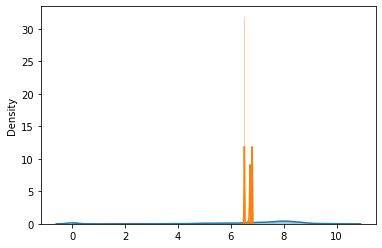

-------------------------------------------------------------
groupNum_train 10 (422507, 38)
cat_features [33, 34, 35, 36, 37]
[ 1  2  3  4  5  7  8 10 11]
train 281671 valid 140836
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 64)                2496      
                                                                 
 dropout_18 (Dropout)        (None, 64)                0         
                                                                 
 dense_25 (Dense)            (None, 32)                2080      
                                                                 
 dropout_19 (Dropout)        (None, 32)                0         
                                                                 
 dense_26 (Dense)            (None, 16)                528       
                                                                 
 dro

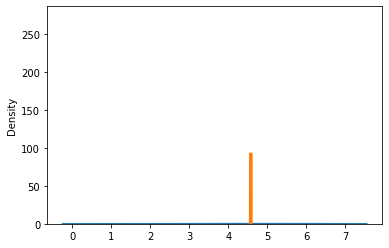

-------------------------------------------------------------
groupNum_train 13 (105375, 38)
cat_features [33, 34, 35, 36, 37]
[1 2 3 4 5]
train 70250 valid 35125
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 64)                2496      
                                                                 
 dropout_27 (Dropout)        (None, 64)                0         
                                                                 
 dense_37 (Dense)            (None, 32)                2080      
                                                                 
 dropout_28 (Dropout)        (None, 32)                0         
                                                                 
 dense_38 (Dense)            (None, 16)                528       
                                                                 
 dropout_29 (Dropout)  

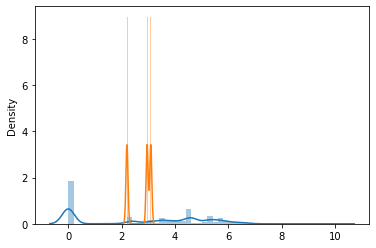

-------------------------------------------------------------
groupNum_train 20 (1157326, 38)
cat_features [33, 34, 35, 36, 37]
[1 2 3 4 5 6 7 8 9]
train 771550 valid 385776
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 64)                2496      
                                                                 
 dropout_36 (Dropout)        (None, 64)                0         
                                                                 
 dense_49 (Dense)            (None, 32)                2080      
                                                                 
 dropout_37 (Dropout)        (None, 32)                0         
                                                                 
 dense_50 (Dense)            (None, 16)                528       
                                                                 
 dropout_38

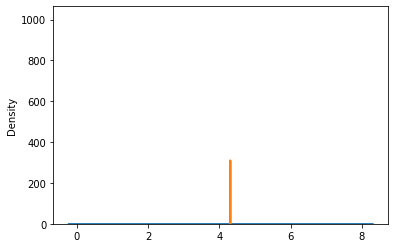

-------------------------------------------------------------
groupNum_train 21 (840114, 38)
cat_features [33, 34, 35, 36, 37]
[1 2 3 4 5 6 7]
train 560076 valid 280038
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_60 (Dense)            (None, 64)                2496      
                                                                 
 dropout_45 (Dropout)        (None, 64)                0         
                                                                 
 dense_61 (Dense)            (None, 32)                2080      
                                                                 
 dropout_46 (Dropout)        (None, 32)                0         
                                                                 
 dense_62 (Dense)            (None, 16)                528       
                                                                 
 dropout_47 (Dro

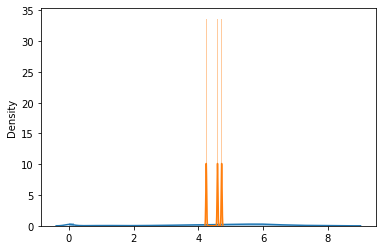

-------------------------------------------------------------
groupNum_train 23 (481810, 38)
cat_features [33, 34, 35, 36, 37]
[1 2 3 4 5]
train 321206 valid 160604
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_72 (Dense)            (None, 64)                2496      
                                                                 
 dropout_54 (Dropout)        (None, 64)                0         
                                                                 
 dense_73 (Dense)            (None, 32)                2080      
                                                                 
 dropout_55 (Dropout)        (None, 32)                0         
                                                                 
 dense_74 (Dense)            (None, 16)                528       
                                                                 
 dropout_56 (Dropout

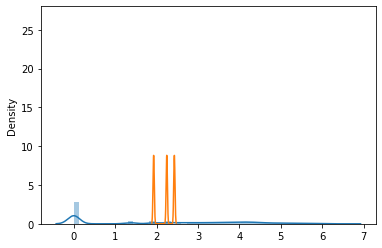

-------------------------------------------------------------
groupNum_train 30 (2368873, 38)
cat_features [33, 34, 35, 36, 37]
[ 1  2  3  4  5  6  7  8 12]
train 1579248 valid 789625
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_84 (Dense)            (None, 64)                2496      
                                                                 
 dropout_63 (Dropout)        (None, 64)                0         
                                                                 
 dense_85 (Dense)            (None, 32)                2080      
                                                                 
 dropout_64 (Dropout)        (None, 32)                0         
                                                                 
 dense_86 (Dense)            (None, 16)                528       
                                                                 
 

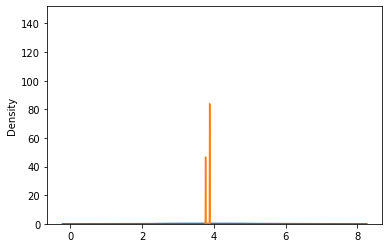

-------------------------------------------------------------
groupNum_train 40 (746461, 38)
cat_features [33, 34, 35, 36, 37]
[ 1  2  3  4  5  6  7  8  9 10 11 12]
train 497640 valid 248821
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_96 (Dense)            (None, 64)                2496      
                                                                 
 dropout_72 (Dropout)        (None, 64)                0         
                                                                 
 dense_97 (Dense)            (None, 32)                2080      
                                                                 
 dropout_73 (Dropout)        (None, 32)                0         
                                                                 
 dense_98 (Dense)            (None, 16)                528       
                                                            

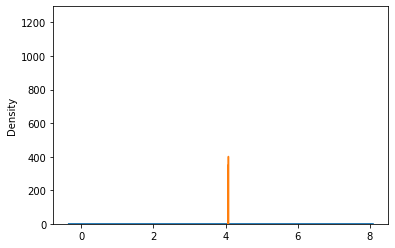

-------------------------------------------------------------
groupNum_train 50 (775395, 38)
cat_features [33, 34, 35, 36, 37]
[1 2 3 4 5 6 7]
train 516930 valid 258465
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_108 (Dense)           (None, 64)                2496      
                                                                 
 dropout_81 (Dropout)        (None, 64)                0         
                                                                 
 dense_109 (Dense)           (None, 32)                2080      
                                                                 
 dropout_82 (Dropout)        (None, 32)                0         
                                                                 
 dense_110 (Dense)           (None, 16)                528       
                                                                 
 dropout_83 (Dro

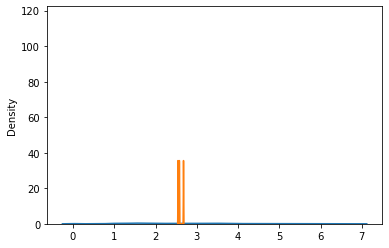

-------------------------------------------------------------
groupNum_train 60 (309558, 38)
cat_features [33, 34, 35, 36, 37]
[ 1  2  3  4  5  9 10]
train 206372 valid 103186
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_120 (Dense)           (None, 64)                2496      
                                                                 
 dropout_90 (Dropout)        (None, 64)                0         
                                                                 
 dense_121 (Dense)           (None, 32)                2080      
                                                                 
 dropout_91 (Dropout)        (None, 32)                0         
                                                                 
 dense_122 (Dense)           (None, 16)                528       
                                                                 
 dropout_

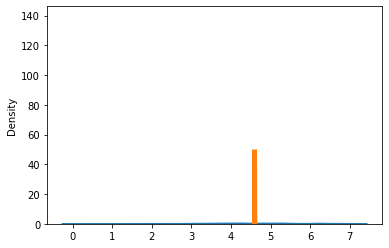

-------------------------------------------------------------
groupNum_train 62 (188590, 38)
cat_features [33, 34, 35, 36, 37]
[ 1  2  3  4  5  9 10]
train 125726 valid 62864
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_132 (Dense)           (None, 64)                2496      
                                                                 
 dropout_99 (Dropout)        (None, 64)                0         
                                                                 
 dense_133 (Dense)           (None, 32)                2080      
                                                                 
 dropout_100 (Dropout)       (None, 32)                0         
                                                                 
 dense_134 (Dense)           (None, 16)                528       
                                                                 
 dropout_1

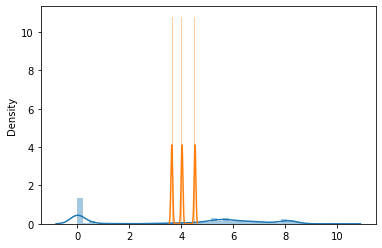

-------------------------------------------------------------
groupNum_train 61 (161567, 38)
cat_features [33, 34, 35, 36, 37]
[1 2 3 4 5 6]
train 107711 valid 53856
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_144 (Dense)           (None, 64)                2496      
                                                                 
 dropout_108 (Dropout)       (None, 64)                0         
                                                                 
 dense_145 (Dense)           (None, 32)                2080      
                                                                 
 dropout_109 (Dropout)       (None, 32)                0         
                                                                 
 dense_146 (Dense)           (None, 16)                528       
                                                                 
 dropout_110 (Dropo

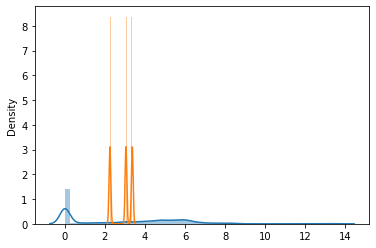

-------------------------------------------------------------
groupNum_train 71 (130956, 38)
cat_features [33, 34, 35, 36, 37]
[1 2 3 4 5]
train 87304 valid 43652
Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_156 (Dense)           (None, 64)                2496      
                                                                 
 dropout_117 (Dropout)       (None, 64)                0         
                                                                 
 dense_157 (Dense)           (None, 32)                2080      
                                                                 
 dropout_118 (Dropout)       (None, 32)                0         
                                                                 
 dense_158 (Dense)           (None, 16)                528       
                                                                 
 dropout_119 (Dropout)

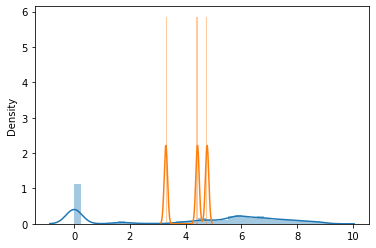

-------------------------------------------------------------
groupNum_train 72 (104597, 38)
cat_features [33, 34, 35, 36, 37]
[1 2 3 4 5]
train 69731 valid 34866
Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_168 (Dense)           (None, 64)                2496      
                                                                 
 dropout_126 (Dropout)       (None, 64)                0         
                                                                 
 dense_169 (Dense)           (None, 32)                2080      
                                                                 
 dropout_127 (Dropout)       (None, 32)                0         
                                                                 
 dense_170 (Dense)           (None, 16)                528       
                                                                 
 dropout_128 (Dropout)

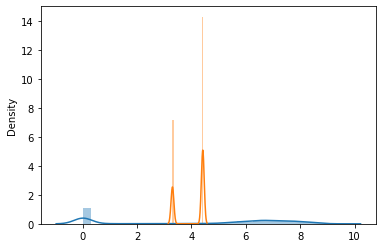

-------------------------------------------------------------
groupNum_train 70 (90893, 38)
cat_features [33, 34, 35, 36, 37]
[ 1  2  3  4  5  8  9 10]
train 60595 valid 30298
Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_180 (Dense)           (None, 64)                2496      
                                                                 
 dropout_135 (Dropout)       (None, 64)                0         
                                                                 
 dense_181 (Dense)           (None, 32)                2080      
                                                                 
 dropout_136 (Dropout)       (None, 32)                0         
                                                                 
 dense_182 (Dense)           (None, 16)                528       
                                                                 
 dropout_

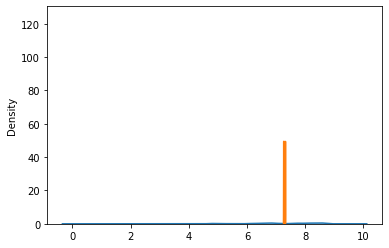

-------------------------------------------------------------
groupNum_train 73 (26344, 38)
cat_features [33, 34, 35, 36, 37]
[1 2 3 4 5]
train 17562 valid 8782
Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_192 (Dense)           (None, 64)                2496      
                                                                 
 dropout_144 (Dropout)       (None, 64)                0         
                                                                 
 dense_193 (Dense)           (None, 32)                2080      
                                                                 
 dropout_145 (Dropout)       (None, 32)                0         
                                                                 
 dense_194 (Dense)           (None, 16)                528       
                                                                 
 dropout_146 (Dropout)  

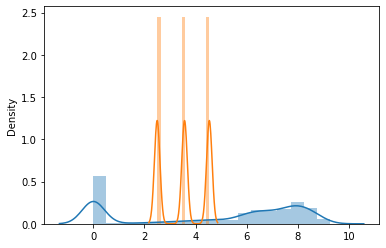

-------------------------------------------------------------
groupNum_train 80 (556575, 38)
cat_features [33, 34, 35, 36, 37]
[1 2 3 4 5 6]
train 371050 valid 185525
Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_204 (Dense)           (None, 64)                2496      
                                                                 
 dropout_153 (Dropout)       (None, 64)                0         
                                                                 
 dense_205 (Dense)           (None, 32)                2080      
                                                                 
 dropout_154 (Dropout)       (None, 32)                0         
                                                                 
 dense_206 (Dense)           (None, 16)                528       
                                                                 
 dropout_155 (Drop

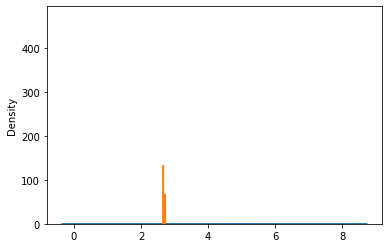

-------------------------------------------------------------
groupNum_train 90 (1012123, 38)
cat_features [33, 34, 35, 36, 37]
[1 2 3 4 5 6 7 8 9]
train 674748 valid 337375
Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_216 (Dense)           (None, 64)                2496      
                                                                 
 dropout_162 (Dropout)       (None, 64)                0         
                                                                 
 dense_217 (Dense)           (None, 32)                2080      
                                                                 
 dropout_163 (Dropout)       (None, 32)                0         
                                                                 
 dense_218 (Dense)           (None, 16)                528       
                                                                 
 dropout_16

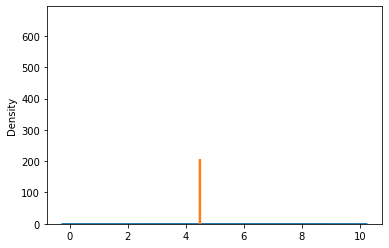

-------------------------------------------------------------
groupNum_train 91 (791828, 38)
cat_features [33, 34, 35, 36, 37]
[1 2 3 4 5 8 9]
train 527885 valid 263943
Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_228 (Dense)           (None, 64)                2496      
                                                                 
 dropout_171 (Dropout)       (None, 64)                0         
                                                                 
 dense_229 (Dense)           (None, 32)                2080      
                                                                 
 dropout_172 (Dropout)       (None, 32)                0         
                                                                 
 dense_230 (Dense)           (None, 16)                528       
                                                                 
 dropout_173 (Dr

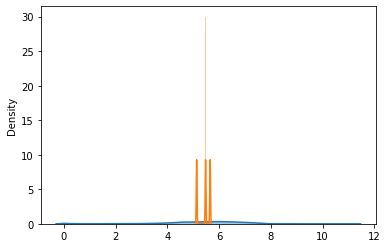

-------------------------------------------------------------
groupNum_train 92 (738143, 38)
cat_features [33, 34, 35, 36, 37]
[1 2 3 4 5 6 7 8 9]
train 492095 valid 246048
Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_240 (Dense)           (None, 64)                2496      
                                                                 
 dropout_180 (Dropout)       (None, 64)                0         
                                                                 
 dense_241 (Dense)           (None, 32)                2080      
                                                                 
 dropout_181 (Dropout)       (None, 32)                0         
                                                                 
 dense_242 (Dense)           (None, 16)                528       
                                                                 
 dropout_182

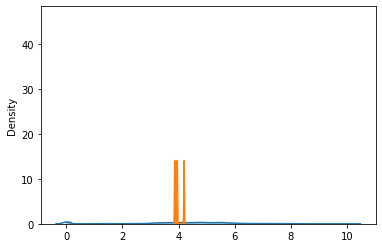

-------------------------------------------------------------
groupNum_train 100 (236046, 38)
cat_features [33, 34, 35, 36, 37]
[1 2 3 4 5 7]
train 157364 valid 78682
Model: "sequential_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_252 (Dense)           (None, 64)                2496      
                                                                 
 dropout_189 (Dropout)       (None, 64)                0         
                                                                 
 dense_253 (Dense)           (None, 32)                2080      
                                                                 
 dropout_190 (Dropout)       (None, 32)                0         
                                                                 
 dense_254 (Dense)           (None, 16)                528       
                                                                 
 dropout_191 (Drop

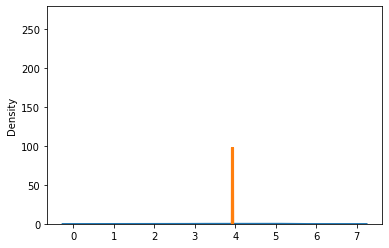

-------------------------------------------------------------
groupNum_train 101 (78935, 38)
cat_features [33, 34, 35, 36, 37]
[1 2 3 4 5]
train 52623 valid 26312
Model: "sequential_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_264 (Dense)           (None, 64)                2496      
                                                                 
 dropout_198 (Dropout)       (None, 64)                0         
                                                                 
 dense_265 (Dense)           (None, 32)                2080      
                                                                 
 dropout_199 (Dropout)       (None, 32)                0         
                                                                 
 dense_266 (Dense)           (None, 16)                528       
                                                                 
 dropout_200 (Dropout)

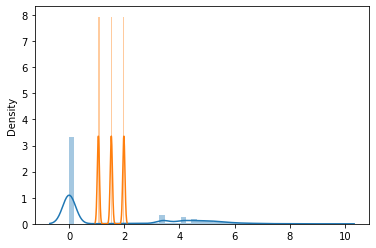

-------------------------------------------------------------
groupNum_train 103 (95899, 38)
cat_features [33, 34, 35, 36, 37]
[1 2 3 4 5]
train 63932 valid 31967
Model: "sequential_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_276 (Dense)           (None, 64)                2496      
                                                                 
 dropout_207 (Dropout)       (None, 64)                0         
                                                                 
 dense_277 (Dense)           (None, 32)                2080      
                                                                 
 dropout_208 (Dropout)       (None, 32)                0         
                                                                 
 dense_278 (Dense)           (None, 16)                528       
                                                                 
 dropout_209 (Dropout)

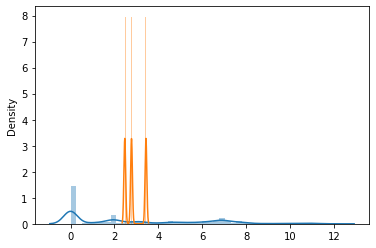

-------------------------------------------------------------
groupNum_train 110 (43400, 38)
cat_features [33, 34, 35, 36, 37]
[1 2 3 4 5]
train 28933 valid 14467
Model: "sequential_72"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_288 (Dense)           (None, 64)                2496      
                                                                 
 dropout_216 (Dropout)       (None, 64)                0         
                                                                 
 dense_289 (Dense)           (None, 32)                2080      
                                                                 
 dropout_217 (Dropout)       (None, 32)                0         
                                                                 
 dense_290 (Dense)           (None, 16)                528       
                                                                 
 dropout_218 (Dropout)

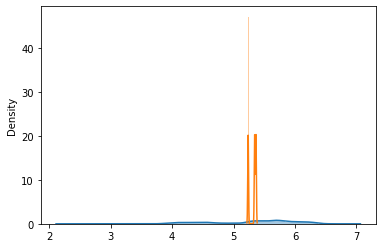

-------------------------------------------------------------
groupNum_train 111 (32656, 38)
cat_features [33, 34, 35, 36, 37]
[1 2 3 4 5]
train 21770 valid 10886
Model: "sequential_75"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_300 (Dense)           (None, 64)                2496      
                                                                 
 dropout_225 (Dropout)       (None, 64)                0         
                                                                 
 dense_301 (Dense)           (None, 32)                2080      
                                                                 
 dropout_226 (Dropout)       (None, 32)                0         
                                                                 
 dense_302 (Dense)           (None, 16)                528       
                                                                 
 dropout_227 (Dropout)

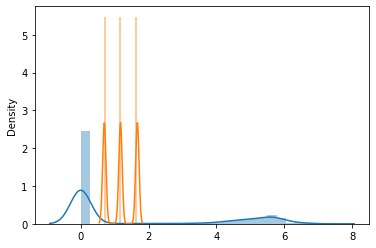

-------------------------------------------------------------
groupNum_train 113 (43403, 38)
cat_features [33, 34, 35, 36, 37]
[1 2 3 4 5]
train 28935 valid 14468
Model: "sequential_78"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_312 (Dense)           (None, 64)                2496      
                                                                 
 dropout_234 (Dropout)       (None, 64)                0         
                                                                 
 dense_313 (Dense)           (None, 32)                2080      
                                                                 
 dropout_235 (Dropout)       (None, 32)                0         
                                                                 
 dense_314 (Dense)           (None, 16)                528       
                                                                 
 dropout_236 (Dropout)

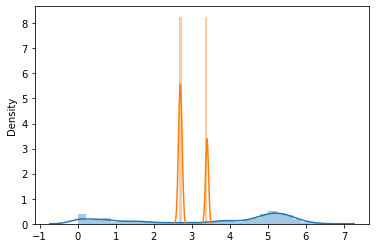

-------------------------------------------------------------
groupNum_train 120 (315909, 38)
cat_features [33, 34, 35, 36, 37]
[1 2 3 4 5]
train 210606 valid 105303
Model: "sequential_81"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_324 (Dense)           (None, 64)                2496      
                                                                 
 dropout_243 (Dropout)       (None, 64)                0         
                                                                 
 dense_325 (Dense)           (None, 32)                2080      
                                                                 
 dropout_244 (Dropout)       (None, 32)                0         
                                                                 
 dense_326 (Dense)           (None, 16)                528       
                                                                 
 dropout_245 (Dropo

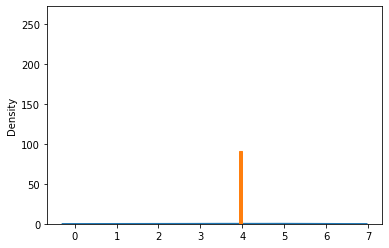

-------------------------------------------------------------
groupNum_train 130 (1205327, 38)
cat_features [33, 34, 35, 36, 37]
[ 1  2  3  4  5  7  8  9 10 11]
train 803551 valid 401776
Model: "sequential_84"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_336 (Dense)           (None, 64)                2496      
                                                                 
 dropout_252 (Dropout)       (None, 64)                0         
                                                                 
 dense_337 (Dense)           (None, 32)                2080      
                                                                 
 dropout_253 (Dropout)       (None, 32)                0         
                                                                 
 dense_338 (Dense)           (None, 16)                528       
                                                                

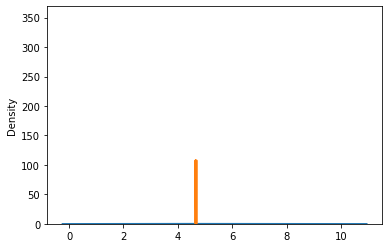

-------------------------------------------------------------
groupNum_train 131 (702607, 38)
cat_features [33, 34, 35, 36, 37]
[1 2 3 4 5]
train 468404 valid 234203
Model: "sequential_87"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_348 (Dense)           (None, 64)                2496      
                                                                 
 dropout_261 (Dropout)       (None, 64)                0         
                                                                 
 dense_349 (Dense)           (None, 32)                2080      
                                                                 
 dropout_262 (Dropout)       (None, 32)                0         
                                                                 
 dense_350 (Dense)           (None, 16)                528       
                                                                 
 dropout_263 (Dropo

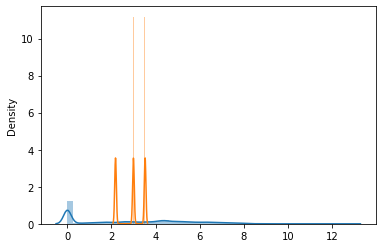

-------------------------------------------------------------
groupNum_train 132 (763712, 38)
cat_features [33, 34, 35, 36, 37]
[1 2 3 4 5]
train 509141 valid 254571
Model: "sequential_90"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_360 (Dense)           (None, 64)                2496      
                                                                 
 dropout_270 (Dropout)       (None, 64)                0         
                                                                 
 dense_361 (Dense)           (None, 32)                2080      
                                                                 
 dropout_271 (Dropout)       (None, 32)                0         
                                                                 
 dense_362 (Dense)           (None, 16)                528       
                                                                 
 dropout_272 (Dropo

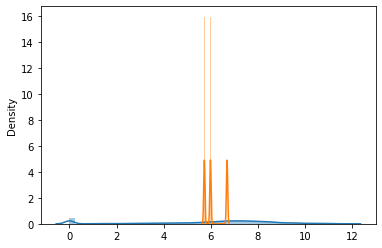

-------------------------------------------------------------
groupNum_train 140 (850670, 38)
cat_features [33, 34, 35, 36, 37]
[1 2 3 4 5 6 7 8]
train 567113 valid 283557
Model: "sequential_93"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_372 (Dense)           (None, 64)                2496      
                                                                 
 dropout_279 (Dropout)       (None, 64)                0         
                                                                 
 dense_373 (Dense)           (None, 32)                2080      
                                                                 
 dropout_280 (Dropout)       (None, 32)                0         
                                                                 
 dense_374 (Dense)           (None, 16)                528       
                                                                 
 dropout_281 

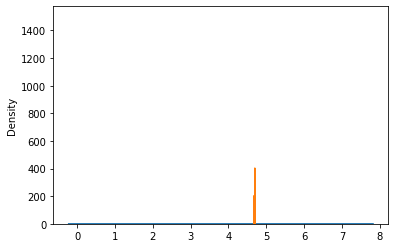

-------------------------------------------------------------
groupNum_train 141 (717154, 38)
cat_features [33, 34, 35, 36, 37]
[1 2 3 4 5 6]
train 478102 valid 239052
Model: "sequential_96"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_384 (Dense)           (None, 64)                2496      
                                                                 
 dropout_288 (Dropout)       (None, 64)                0         
                                                                 
 dense_385 (Dense)           (None, 32)                2080      
                                                                 
 dropout_289 (Dropout)       (None, 32)                0         
                                                                 
 dense_386 (Dense)           (None, 16)                528       
                                                                 
 dropout_290 (Dro

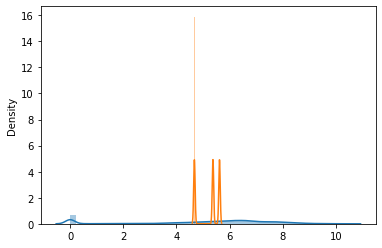

-------------------------------------------------------------
groupNum_train 143 (487253, 38)
cat_features [33, 34, 35, 36, 37]
[1 2 3 4 5 6 7]
train 324835 valid 162418
Model: "sequential_99"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_396 (Dense)           (None, 64)                2496      
                                                                 
 dropout_297 (Dropout)       (None, 64)                0         
                                                                 
 dense_397 (Dense)           (None, 32)                2080      
                                                                 
 dropout_298 (Dropout)       (None, 32)                0         
                                                                 
 dense_398 (Dense)           (None, 16)                528       
                                                                 
 dropout_299 (D

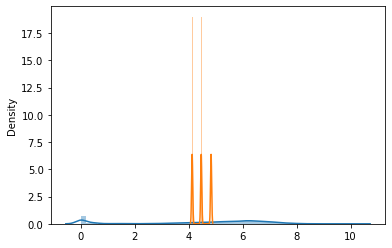

-------------------------------------------------------------
groupNum_train 142 (346087, 38)
cat_features [33, 34, 35, 36, 37]
[ 1  2  3  4  5  6  7  8 12]
train 230724 valid 115363
Model: "sequential_102"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_408 (Dense)           (None, 64)                2496      
                                                                 
 dropout_306 (Dropout)       (None, 64)                0         
                                                                 
 dense_409 (Dense)           (None, 32)                2080      
                                                                 
 dropout_307 (Dropout)       (None, 32)                0         
                                                                 
 dense_410 (Dense)           (None, 16)                528       
                                                                 
 

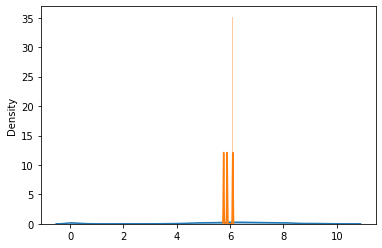

-------------------------------------------------------------
groupNum_train 153 (14797, 38)
cat_features [33, 34, 35, 36, 37]
[1 2 3 4 5 6]
train 9864 valid 4933
Model: "sequential_105"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_420 (Dense)           (None, 64)                2496      
                                                                 
 dropout_315 (Dropout)       (None, 64)                0         
                                                                 
 dense_421 (Dense)           (None, 32)                2080      
                                                                 
 dropout_316 (Dropout)       (None, 32)                0         
                                                                 
 dense_422 (Dense)           (None, 16)                528       
                                                                 
 dropout_317 (Dropout

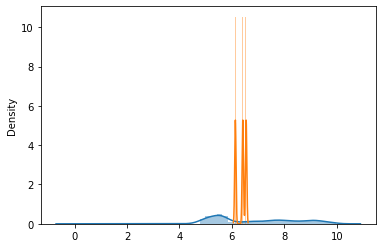

-------------------------------------------------------------
groupNum_train 150 (837587, 38)
cat_features [33, 34, 35, 36, 37]
[ 1  2  3  4  5  6  7  9 10]
train 558391 valid 279196
Model: "sequential_108"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_432 (Dense)           (None, 64)                2496      
                                                                 
 dropout_324 (Dropout)       (None, 64)                0         
                                                                 
 dense_433 (Dense)           (None, 32)                2080      
                                                                 
 dropout_325 (Dropout)       (None, 32)                0         
                                                                 
 dense_434 (Dense)           (None, 16)                528       
                                                                 
 

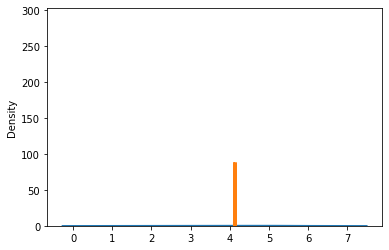

-------------------------------------------------------------
groupNum_train 151 (464951, 38)
cat_features [33, 34, 35, 36, 37]
[ 1  2  3  4  5  6 11 12]
train 309967 valid 154984
Model: "sequential_111"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_444 (Dense)           (None, 64)                2496      
                                                                 
 dropout_333 (Dropout)       (None, 64)                0         
                                                                 
 dense_445 (Dense)           (None, 32)                2080      
                                                                 
 dropout_334 (Dropout)       (None, 32)                0         
                                                                 
 dense_446 (Dense)           (None, 16)                528       
                                                                 
 dro

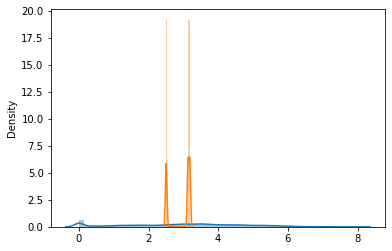

-------------------------------------------------------------
groupNum_train 152 (493598, 38)
cat_features [33, 34, 35, 36, 37]
[ 1  2  3  4  5  6  7  8  9 10 12]
train 329065 valid 164533
Model: "sequential_114"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_456 (Dense)           (None, 64)                2496      
                                                                 
 dropout_342 (Dropout)       (None, 64)                0         
                                                                 
 dense_457 (Dense)           (None, 32)                2080      
                                                                 
 dropout_343 (Dropout)       (None, 32)                0         
                                                                 
 dense_458 (Dense)           (None, 16)                528       
                                                             

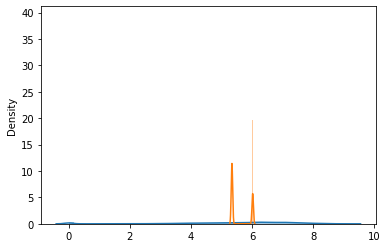

-------------------------------------------------------------


In [37]:
for groupNum_train in building_meta_df['groupNum_train'].unique():
    X_train, y_train = create_X_y(train_df, groupNum_train=groupNum_train)
    y_valid_pred_total = np.zeros(X_train.shape[0])
    gc.collect()
    print('groupNum_train', groupNum_train, X_train.shape)

    cat_features = [X_train.columns.get_loc(
        cat_col) for cat_col in category_cols]
    print('cat_features', cat_features)

    exec('models' + str(groupNum_train) + '=[]')

    train_df_site = train_df[train_df['groupNum_train']
                             == groupNum_train].copy()

    
    for train_idx, valid_idx in kf.split(train_df_site, train_df_site['building_id']):
        train_data = X_train.iloc[train_idx, :], y_train[train_idx]
        valid_data = X_train.iloc[valid_idx, :], y_train[valid_idx]

        mindex = train_df_site.iloc[valid_idx, :].month.unique()
        print(mindex)

        print('train', len(train_idx), 'valid', len(valid_idx))
    
        model, y_pred_valid= RNN_LSTM(train_data, valid_data) # How to pass and train the categorical data
        
        
        y_valid_pred_total[valid_idx] = y_pred_valid.reshape(-1)
        exec('models' + str(groupNum_train) + '.append([mindex, model])')
        gc.collect()
        if debug:
            break

    try:
        sns.distplot(y_train)
        sns.distplot(y_valid_pred_total)
        plt.show()
    except:
        pass

    del X_train, y_train
    gc.collect()

    print('-------------------------------------------------------------')

In [38]:
# Prediction on test data¶

print('loading...')
test_df = pd.read_feather(root/'test.feather')
weather_test_df = pd.read_feather(root/'weather_test.feather')

print('Before Preprocessing ....')
print('Shape of test data: ', test_df.shape)
print('Shape of Weather test data: ', weather_test_df.shape)

weather_test_df = weather_test_df.drop_duplicates(['timestamp', 'site_id'])
set_local(weather_test_df)
add_holiyday(weather_test_df)

print('preprocessing building...')
test_df['date'] = test_df['timestamp'].dt.date
preprocess(test_df)


print('preprocessing weather...')
weather_test_df = weather_test_df.groupby('site_id').apply(
    lambda group: group.interpolate(method='ffill', limit_direction='forward'))
weather_test_df.groupby('site_id').apply(lambda group: group.isna().sum())

add_sg(weather_test_df)

add_lag_feature(weather_test_df, window=3)
add_lag_feature(weather_test_df, window=72)

test_df['bid_cnt'] = test_df.building_id.map(bid_map)

test_df = test_df.merge(building_meta_df[['building_id', 'meter', 'groupNum_train','square_feet']], on=[
                        'building_id', 'meter'], how='left')

test_df['square_feet_np_log1p'] = np.log1p(test_df['square_feet'])

print('reduce mem usage...')
test_df = reduce_mem_usage(test_df, use_float16=True)
weather_test_df = reduce_mem_usage(weather_test_df, use_float16=True)

gc.collect()

loading...
Before Preprocessing ....
Shape of test data:  (41697600, 4)
Shape of Weather test data:  (277243, 9)
preprocessing building...
preprocessing weather...
reduce mem usage...
Memory usage of dataframe is 3698.23 MB
Memory usage after optimization is: 1590.66 MB
Decreased by 57.0%
Memory usage of dataframe is 48.12 MB
Memory usage after optimization is: 41.51 MB
Decreased by 13.7%


21

In [39]:
# %% [code]
sample_submission = pd.read_feather(
    os.path.join(root, 'sample_submission.feather'))
reduce_mem_usage(sample_submission)

print(sample_submission.shape)

Memory usage of dataframe is 636.26 MB
Memory usage after optimization is: 198.83 MB
Decreased by 68.7%
(41697600, 2)


In [40]:
def create_X(test_df, groupNum_train):

    target_test_df = test_df[test_df['groupNum_train']
                             == groupNum_train].copy()
    # target_test_df = target_test_df.merge(df_groupNum_median, on=['timestamp'], how='left')
    target_test_df = target_test_df.merge(
        building_meta_df, on=['building_id', 'meter', 'groupNum_train'], how='left')
    target_test_df = target_test_df.merge(
        weather_test_df, on=['site_id', 'timestamp'], how='left')
    #target_test_df['group_median_'+str(groupNum_train)] = np.nan

    X_test = target_test_df[feature_cols + category_cols]

    return X_test

In [41]:

def pred_all(X_test, models, batch_size=10000):
    iterations = (X_test.shape[1] + batch_size - 1) // batch_size
    print('iterations', iterations)

    y_test_pred_total = np.zeros(X_test.shape[0])
    for i, (mindex, model) in enumerate(models):
        print(f'predicting {i}-th model')
        for k in tqdm(range(iterations)):
            y_pred_test = model.predict(
                X_test[k*batch_size:(k+1)*batch_size]) #num_iteration=model.best_iteration
            y_test_pred_total[k*batch_size:(k+1)*batch_size] += y_pred_test.reshape(-1)

    y_test_pred_total /= len(models)
    return y_test_pred_total


def pred(X_test, models, batch_size=10000):
        print('all pred')
        return pred_all(X_test, models, batch_size=10000)

groupNum_train:  0
all pred
iterations 1
predicting 0-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/1 [00:00<?, ?it/s]

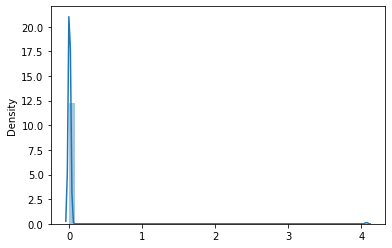

(1839600, 38) (1839600,)
groupNum_train:  1
all pred
iterations 1
predicting 0-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/1 [00:00<?, ?it/s]

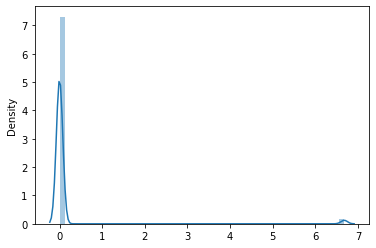

(420480, 38) (420480,)
groupNum_train:  10
all pred
iterations 1
predicting 0-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/1 [00:00<?, ?it/s]

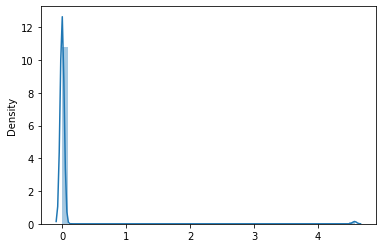

(893520, 38) (893520,)
groupNum_train:  13
all pred
iterations 1
predicting 0-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/1 [00:00<?, ?it/s]

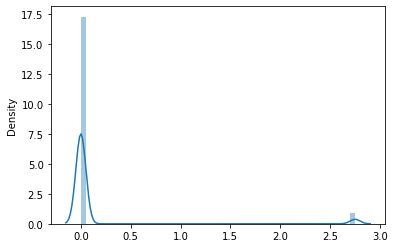

(210240, 38) (210240,)
groupNum_train:  20
all pred
iterations 1
predicting 0-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/1 [00:00<?, ?it/s]

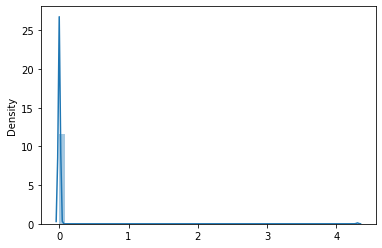

(2365200, 38) (2365200,)
groupNum_train:  21
all pred
iterations 1
predicting 0-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/1 [00:00<?, ?it/s]

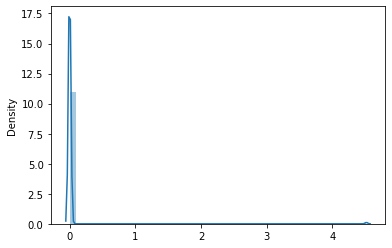

(1734480, 38) (1734480,)
groupNum_train:  23
all pred
iterations 1
predicting 0-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/1 [00:00<?, ?it/s]

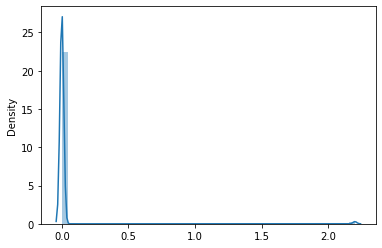

(963600, 38) (963600,)
groupNum_train:  30
all pred
iterations 1
predicting 0-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/1 [00:00<?, ?it/s]

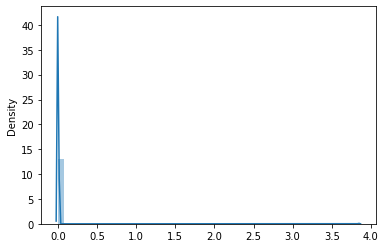

(4800480, 38) (4800480,)
groupNum_train:  40
all pred
iterations 1
predicting 0-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/1 [00:00<?, ?it/s]

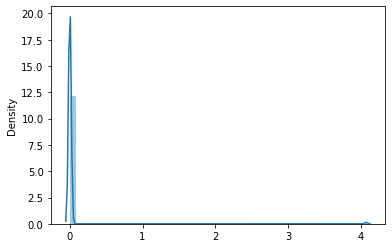

(1594320, 38) (1594320,)
groupNum_train:  50
all pred
iterations 1
predicting 0-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/1 [00:00<?, ?it/s]

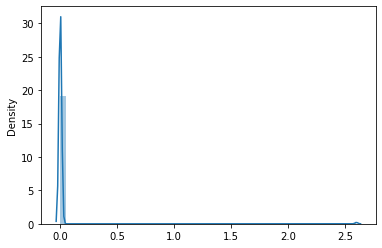

(1559280, 38) (1559280,)
groupNum_train:  60
all pred
iterations 1
predicting 0-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/1 [00:00<?, ?it/s]

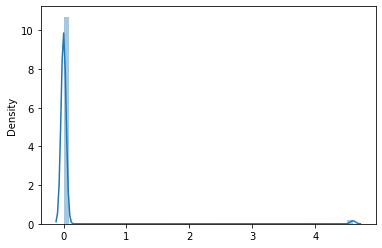

(630720, 38) (630720,)
groupNum_train:  62
all pred
iterations 1
predicting 0-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/1 [00:00<?, ?it/s]

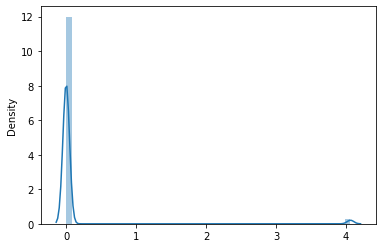

(402960, 38) (402960,)
groupNum_train:  61
all pred
iterations 1
predicting 0-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/1 [00:00<?, ?it/s]

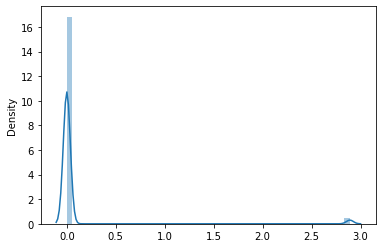

(367920, 38) (367920,)
groupNum_train:  71
all pred
iterations 1
predicting 0-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/1 [00:00<?, ?it/s]

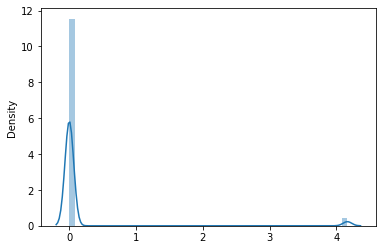

(262800, 38) (262800,)
groupNum_train:  72
all pred
iterations 1
predicting 0-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/1 [00:00<?, ?it/s]

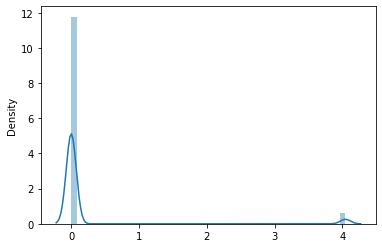

(210240, 38) (210240,)
groupNum_train:  70
all pred
iterations 1
predicting 0-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/1 [00:00<?, ?it/s]

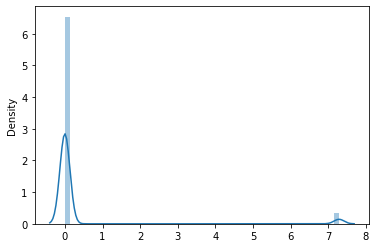

(210240, 38) (210240,)
groupNum_train:  73
all pred
iterations 1
predicting 0-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/1 [00:00<?, ?it/s]

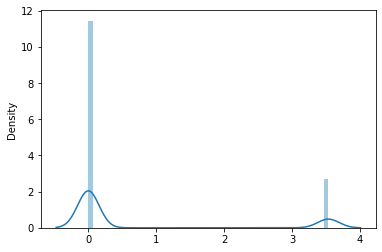

(52560, 38) (52560,)
groupNum_train:  80
all pred
iterations 1
predicting 0-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/1 [00:00<?, ?it/s]

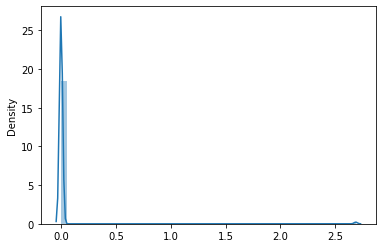

(1226400, 38) (1226400,)
groupNum_train:  90
all pred
iterations 1
predicting 0-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/1 [00:00<?, ?it/s]

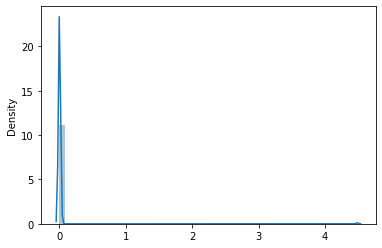

(2137440, 38) (2137440,)
groupNum_train:  91
all pred
iterations 1
predicting 0-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/1 [00:00<?, ?it/s]

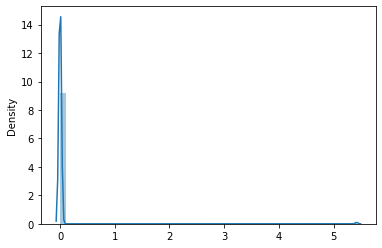

(1664400, 38) (1664400,)
groupNum_train:  92
all pred
iterations 1
predicting 0-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/1 [00:00<?, ?it/s]

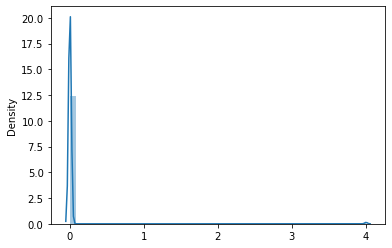

(1559280, 38) (1559280,)
groupNum_train:  100
all pred
iterations 1
predicting 0-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/1 [00:00<?, ?it/s]

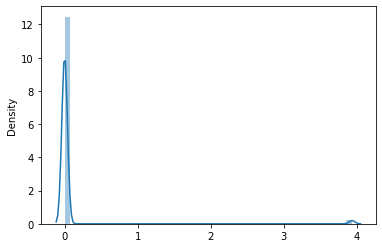

(525600, 38) (525600,)
groupNum_train:  101
all pred
iterations 1
predicting 0-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/1 [00:00<?, ?it/s]

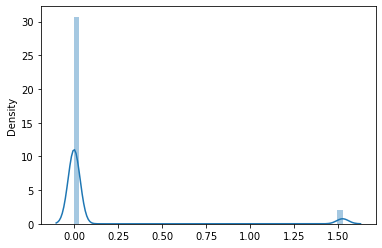

(157680, 38) (157680,)
groupNum_train:  103
all pred
iterations 1
predicting 0-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/1 [00:00<?, ?it/s]

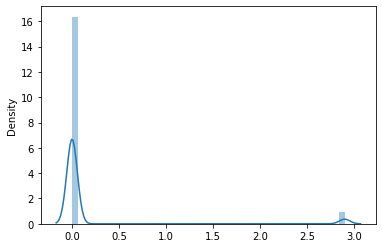

(192720, 38) (192720,)
groupNum_train:  110
all pred
iterations 1
predicting 0-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/1 [00:00<?, ?it/s]

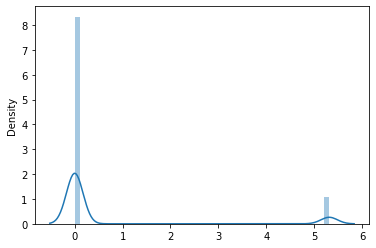

(87600, 38) (87600,)
groupNum_train:  111
all pred
iterations 1
predicting 0-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/1 [00:00<?, ?it/s]

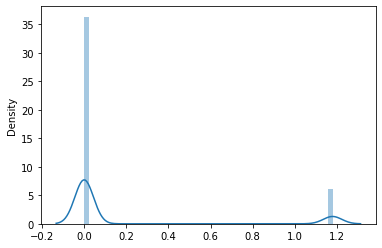

(70080, 38) (70080,)
groupNum_train:  113
all pred
iterations 1
predicting 0-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/1 [00:00<?, ?it/s]

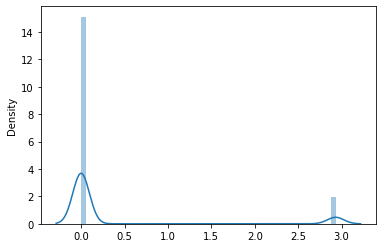

(87600, 38) (87600,)
groupNum_train:  120
all pred
iterations 1
predicting 0-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/1 [00:00<?, ?it/s]

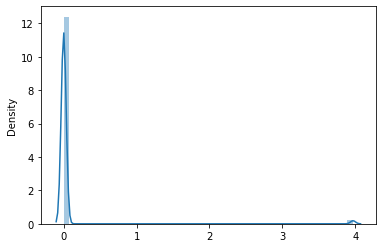

(630720, 38) (630720,)
groupNum_train:  130
all pred
iterations 1
predicting 0-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/1 [00:00<?, ?it/s]

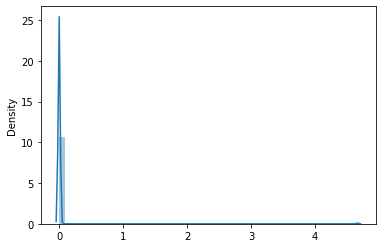

(2470320, 38) (2470320,)
groupNum_train:  131
all pred
iterations 1
predicting 0-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/1 [00:00<?, ?it/s]

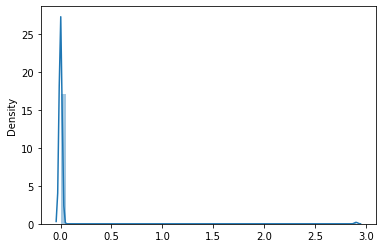

(1401600, 38) (1401600,)
groupNum_train:  132
all pred
iterations 1
predicting 0-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/1 [00:00<?, ?it/s]

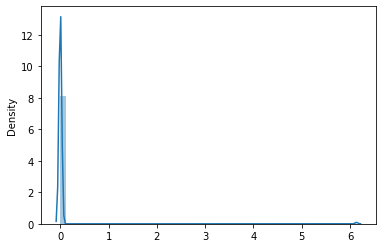

(1541760, 38) (1541760,)
groupNum_train:  140
all pred
iterations 1
predicting 0-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/1 [00:00<?, ?it/s]

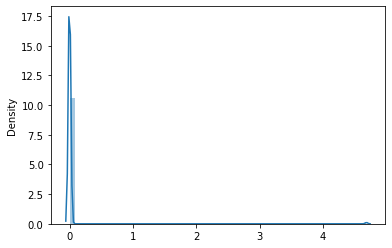

(1787040, 38) (1787040,)
groupNum_train:  141
all pred
iterations 1
predicting 0-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/1 [00:00<?, ?it/s]

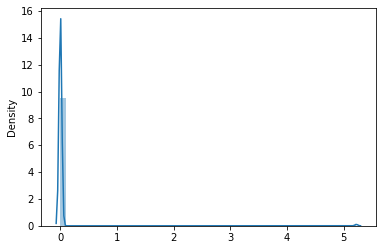

(1506720, 38) (1506720,)
groupNum_train:  143
all pred
iterations 1
predicting 0-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/1 [00:00<?, ?it/s]

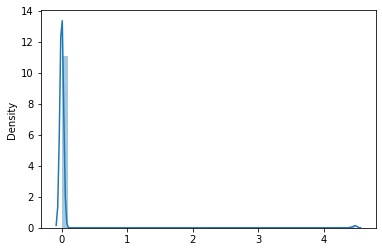

(998640, 38) (998640,)
groupNum_train:  142
all pred
iterations 1
predicting 0-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/1 [00:00<?, ?it/s]

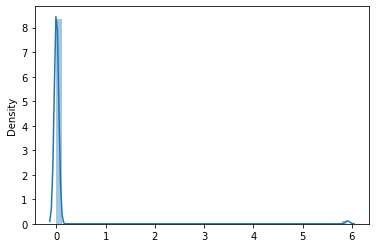

(753360, 38) (753360,)
groupNum_train:  153
all pred
iterations 1
predicting 0-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/1 [00:00<?, ?it/s]

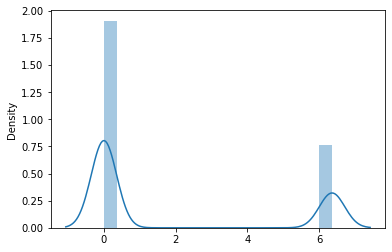

(35040, 38) (35040,)
groupNum_train:  150
all pred
iterations 1
predicting 0-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/1 [00:00<?, ?it/s]

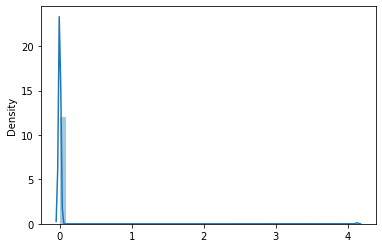

(1997280, 38) (1997280,)
groupNum_train:  151
all pred
iterations 1
predicting 0-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/1 [00:00<?, ?it/s]

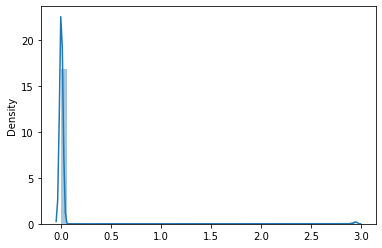

(1138800, 38) (1138800,)
groupNum_train:  152
all pred
iterations 1
predicting 0-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/1 [00:00<?, ?it/s]

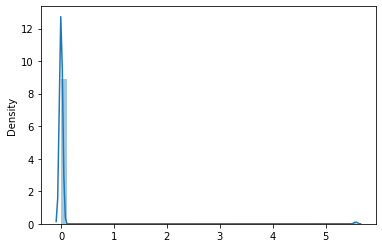

(1208880, 38) (1208880,)


In [42]:
for groupNum_train in building_meta_df['groupNum_train'].unique():
    print('groupNum_train: ', groupNum_train)
    X_test = create_X(test_df, groupNum_train=groupNum_train)
    gc.collect()

    exec('y_test= pred(X_test, models' + str(groupNum_train) + ')')

    sns.distplot(y_test)
    plt.show()

    print(X_test.shape, y_test.shape)
    sample_submission.loc[test_df["groupNum_train"] ==
                          groupNum_train, "meter_reading"] = np.expm1(y_test)

    del X_test, y_test
    gc.collect()

## Site-0 Correction 

In [ ]:
# https://www.kaggle.com/c/ashrae-energy-prediction/discussion/119261#latest-684102
sample_submission.loc[(test_df.building_id.isin(site_0_bids)) & (test_df.meter == 0), 'meter_reading'] = sample_submission[(
    test_df.building_id.isin(site_0_bids)) & (test_df.meter == 0)]['meter_reading'] * 3.4118

In [ ]:
np.log1p(sample_submission['meter_reading']).hist(bins=100)

In [ ]:
if not debug:
    sample_submission.to_csv(
        'submission_LSTM_RNN_firstRun.csv', index=False, float_format='%.4f')


In [ ]:
if not debug:

  ! mkdir -p ~/.kaggle/ && \
    echo '{"username":"joydipbhowmick","key":"5bd4e6a1fec9fc7f8a93def26785a6d2"}' > ~/.kaggle/kaggle.json && \
    chmod 600 ~/.kaggle/kaggle.json # Create a new direcory use the kaggle token key in that and make it read only to current user.
  ! kaggle competitions submit -c ashrae-energy-prediction -f submission_RNN_Dense_layer.csv -m "LSTM RNN Model No Blend First test run - still in debug mode"